<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_ilheus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Jequié/BA
**Fonte**: https://www.instagram.com/prefeiturailheusba/ e https://www.ilheus.ba.gov.br/   
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/ilheus.csv   
**Github**: https://github.com/covidba/covid

In [2]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np

data_atual = date.today().strftime("%d-%m-%Y")
cidade = 'Ilheus'
cidade_file_name = 'ilheus'
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes', 'tendencia'], parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Expectativa']


#set date as index
lista_data = df['data']
df.set_index('data', inplace=True)
df.tail(20)

,Casos confirmados,Casos recuperados,Mortes,Expectativa
data,,,,
2020-05-13,332.0,205.0,16.0,0.0
2020-05-14,336.0,208.0,17.0,0.0
2020-05-15,344.0,208.0,17.0,0.0
2020-05-16,344.0,208.0,17.0,0.0
2020-05-17,360.0,216.0,17.0,0.0
2020-05-18,364.0,216.0,18.0,0.0
2020-05-19,373.0,248.0,20.0,0.0
2020-05-20,385.0,260.0,20.0,0.0
2020-05-21,402.0,263.0,20.0,0.0


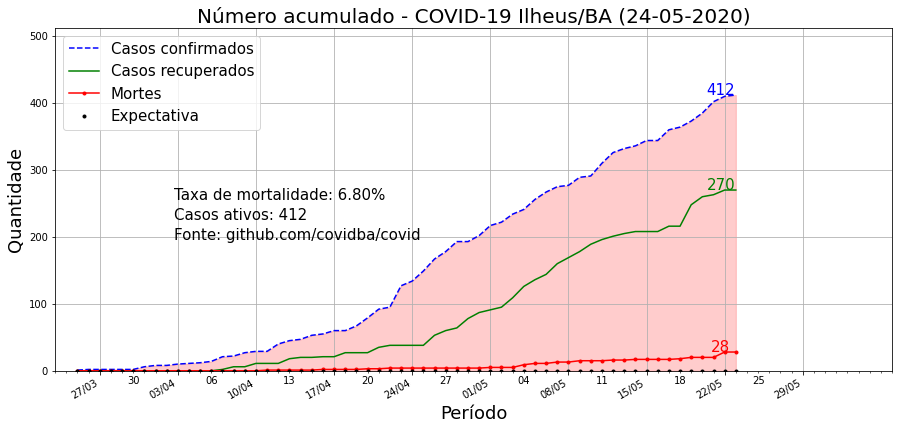

In [20]:
from matplotlib.dates import MO

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(df['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color):
  ax.annotate(int(df[caso].max()), xy=(lista_data[ultimo_caso_valido_id], df[caso].max()), 
              xycoords='data', ha='center', fontsize=15, color=color,
              xytext=(-15, 0), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

taxa_mortalidade = (100 * df['Mortes'].max()) / df['Casos confirmados'].max()
ax.annotate('Taxa de mortalidade: %.2f%%' % taxa_mortalidade , xy=(lista_data.min() + timedelta(days=10), df['Casos confirmados'].max()/2+20), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(-15, 20), textcoords='offset points')
casos_ativos = int(df['Casos confirmados'].max() - df['Casos recuperados'].min())
ax.annotate('Casos ativos: %s' % casos_ativos , xy=(lista_data.min() + timedelta(days=10), df['Casos confirmados'].max()/2+20), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(-15, 0), textcoords='offset points')

url_expectativa = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_expectativa , xy=(lista_data.min() + timedelta(days=10), df['Casos confirmados'].max()/2+20), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(-15, -20), textcoords='offset points')

ax.fill_between(df.index, df['Casos confirmados'], df['Expectativa'], 
                where=df['Casos confirmados']>=df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, df['Casos confirmados'].max() + 100)
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max() + timedelta(days=5)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

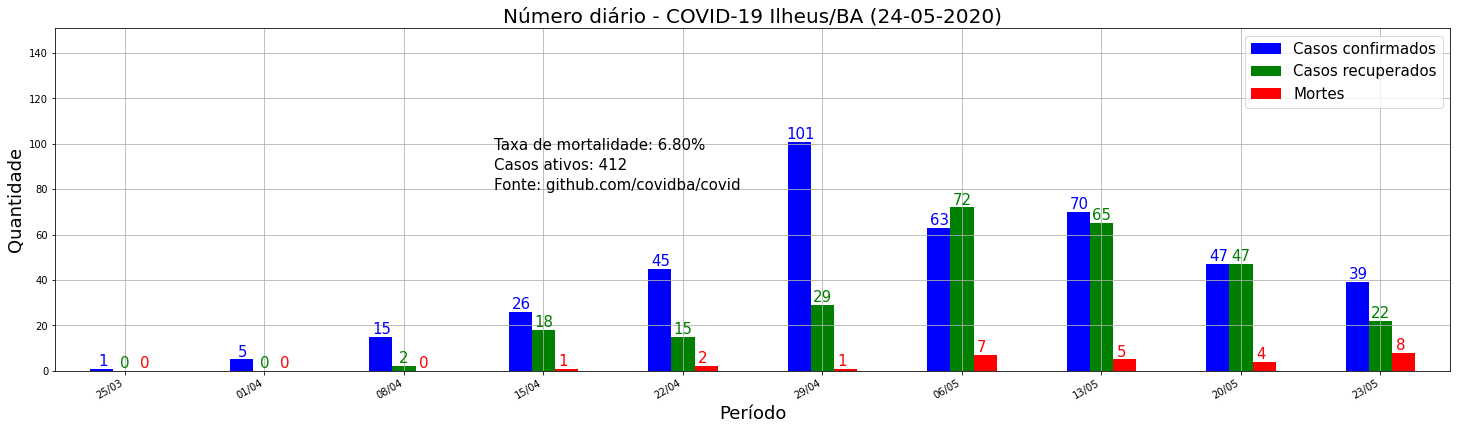

In [40]:
dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []
for id, v in enumerate(df['Casos confirmados']):
  if not pd.isnull(v):
    if(id) == 0:
      casos_confirmados_diaria.append(v)  
    else:
      casos_confirmados_diaria.append(v - df['Casos confirmados'][id-1])
for id, v in enumerate(df['Casos recuperados']):
  if not pd.isnull(v):
    if(id) == 0:
      casos_recuperados_diaria.append(v)  
    else:
       casos_recuperados_diaria.append(v - df['Casos recuperados'][id-1])
for id, v in enumerate(df['Mortes']):
  if not pd.isnull(v):
    if(id) == 0:
       casos_mortes_diaria.append(v) 
    else:
       casos_mortes_diaria.append(v - df['Mortes'][id-1])

frequency = 7
soma_casos = 0
a = 0
for id, v in enumerate(casos_confirmados_diaria):
  if not pd.isnull(v):
    if id % frequency == 0:
      dict_diaria['data'].append(lista_data[id])
      if id == 0:
        dict_diaria['confirmados_diaria'].append(v)
      else:
        dict_diaria['confirmados_diaria'].append(soma_casos)
        soma_casos = v
    else:
      soma_casos += v
      if(len(casos_confirmados_diaria)-1 == id):
        dict_diaria['data'].append(lista_data[id])
        dict_diaria['confirmados_diaria'].append(soma_casos)
    
soma_casos = 0
for id, v in enumerate(casos_recuperados_diaria):
  if not pd.isnull(v):
    if id % frequency == 0:
      if id == 0:
        dict_diaria['recuperados_diaria'].append(v)
      else:
        dict_diaria['recuperados_diaria'].append(soma_casos)
        soma_casos = v
    else:
      soma_casos += v
      if(len(casos_confirmados_diaria)-1 == id):
        dict_diaria['recuperados_diaria'].append(soma_casos)

soma_casos = 0
for id, v in enumerate(casos_mortes_diaria):
  if not pd.isnull(v):
    if id % frequency == 0:
      if id == 0:
        dict_diaria['mortes_diaria'].append(v)
      else:
        dict_diaria['mortes_diaria'].append(soma_casos)
        soma_casos = v
    else:
      soma_casos += v
      if(len(casos_confirmados_diaria)-1 == id):
        dict_diaria['mortes_diaria'].append(soma_casos)

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
novo_df = df_diaria
df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(25,7))
df_diaria.plot(ax=ax, color=colors, kind='bar')
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

for i, v in enumerate(df_diaria['Casos confirmados']):
  if not pd.isnull(v):
    ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color='b',
              xytext=(-22, 3), textcoords='offset points')
  
for i, v in enumerate(df_diaria['Casos recuperados']):
  if not pd.isnull(v):
    ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color='g',
              xytext=(0, 3), textcoords='offset points')
  
for i, v in enumerate(df_diaria['Mortes']):
  if not pd.isnull(v):
    ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color='r',
              xytext=(20, 3), textcoords='offset points')
  
ax.annotate('Taxa de mortalidade: %.2f%%' % taxa_mortalidade , xy=(df_diaria['Mortes'][4], 120), 
            xycoords='data', ha='left', fontsize=15, color='black', xytext=(90, df_diaria['Casos confirmados'][len(df_diaria['Casos confirmados'])-1]-90), textcoords='offset points')
ax.annotate('Casos ativos: %s' % casos_ativos , xy=(df_diaria['Mortes'][4], 120), 
            xycoords='data', ha='left', fontsize=15, color='black', xytext=(90, df_diaria['Casos confirmados'][len(df_diaria['Casos confirmados'])-1]-110), textcoords='offset points')  
url_expectativa = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_expectativa , xy=(df_diaria['Mortes'][4], 120), 
            xycoords='data', ha='left', fontsize=15, color='black', xytext=(90, df_diaria['Casos confirmados'][len(df_diaria['Casos confirmados'])-1]-130), textcoords='offset points')

ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 50])
ax.set_title("Número diário - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

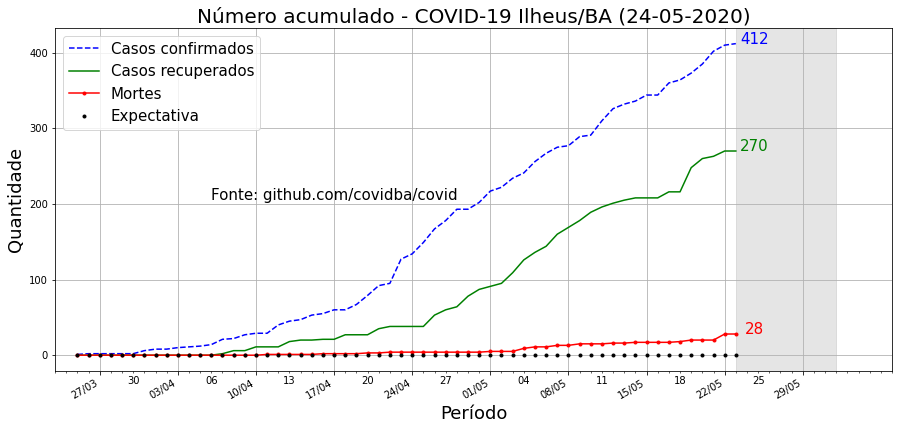

In [26]:
df1 = pd.read_csv(url, usecols=['data', 'restricao'], parse_dates=['data'])
df1.columns = ['data', 'Medida Restritiva']

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df1['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), df1['data'][len(lista_data)-1].strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()])
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()], 100), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
for id, medida in enumerate(df1['Medida Restritiva']):
  # toque de recolher
  if not pd.isnull(medida):
    if medida == 0:
      adicionar_medida('Comércio aberto', id) 
    elif medida == 1:
      adicionar_medida('Comércio fechado', id, color='purple') 
    elif medida > 1:
      if medida == 24:
        adicionar_medida('Saída do toque de recolher', id)
      else:
        adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
    elif medida == -1:
      adicionar_medida('Entrada no lockdown', id, color='purple')
    elif str(medida) == '-0':
      adicionar_medida('Saída do lockdown', id)

# ADICIONAR VALORES
def adicionar_valores(caso, color):
  ax.annotate(int(df[caso].max()), xy=(lista_data[ultimo_caso_valido_id]+timedelta(days=3), df[caso].max()), 
              xycoords='data', ha='center', fontsize=15, color=color,
              xytext=(-15, 0), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')


url_expectativa = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_expectativa , xy=(lista_data[20]+timedelta(days=3), df['Casos confirmados'].max()/2), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max() + timedelta(days=5)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

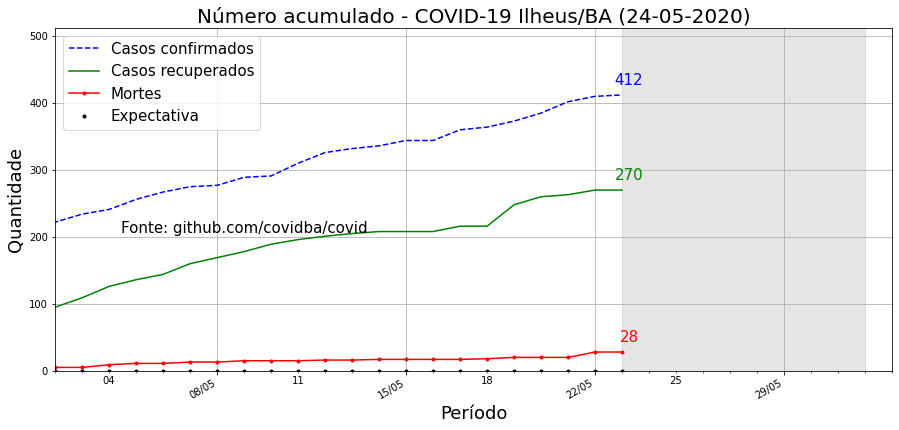

In [25]:
df1 = pd.read_csv(url, usecols=['data', 'restricao'], parse_dates=['data'])
df1.columns = ['data', 'Medida Restritiva']

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df1['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), df1['data'][len(lista_data)-1].strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()])
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()], 100), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
for id, medida in enumerate(df1['Medida Restritiva']):
  # toque de recolher
  if not pd.isnull(medida):
    if medida == 0:
      adicionar_medida('Comércio aberto', id) 
    elif medida == 1:
      adicionar_medida('Comércio fechado', id, color='purple') 
    elif medida > 1:
      if medida == 24:
        adicionar_medida('Saída do toque de recolher', id)
      else:
        adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
    elif medida == -1:
      adicionar_medida('Entrada no lockdown', id, color='purple')
    elif str(medida) == '-0':
      adicionar_medida('Saída do lockdown', id)

# ADICIONAR VALORES
def adicionar_valores(caso, color):
  ax.annotate(int(df[caso].max()), xy=(lista_data[ultimo_caso_valido_id]+timedelta(days=1), df[caso].max()), 
              xycoords='data', ha='center', fontsize=15, color=color,
              xytext=(-20, 10), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')


url_expectativa = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_expectativa , xy=(lista_data[20]+timedelta(days=25), df['Casos confirmados'].max()/2), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_ylim(0, df['Casos confirmados'].max() + 100)
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max() + timedelta(days=1)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)